In [1]:
# -*- coding: utf-8 -*-
import os
import argparse
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms


from metadatas import *
from augmentations import *

from models.classification_heads import ClassificationHead, R2D2Head
from models.classification_heads import ClassificationHead_Mixup, R2D2Head_Mixup
from models.R2D2_embedding import R2D2Embedding
from models.R2D2_embedding_mixup import R2D2Embedding_mixup
from models.protonet_embedding import ProtoNetEmbedding
from models.ResNet12_embedding import resnet12 
from models.ResNet12_embedding_mixup import resnet12_mixup 
from InstaAug_module import learnable_invariance

from utils import set_gpu, Timer, count_accuracy, count_accuracy_mixup, check_dir, log
import matplotlib.pyplot as plt

import pdb
import time
import wandb
import yaml


#np.seterr(all='raise')

def mixup_data(x, y, lam, use_cuda=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).to(DEVICE)
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    loss = 0.
    for i in range(len(pred)):
        loss += lam[i] * criterion(pred[i], y_a[i]) + (1 - lam[i]) * criterion(pred[i], y_b[i])

    return loss/len(pred)


def one_hot(indices, depth):
    """
    Returns a one-hot tensor.
    This is a PyTorch equivalent of Tensorflow's tf.one_hot.
        
    Parameters:
      indices:  a (n_batch, m) Tensor or (m) Tensor.
      depth: a scalar. Represents the depth of the one hot dimension.
    Returns: a (n_batch, m, depth) Tensor or (m, depth) Tensor.
    """

    encoded_indicies = torch.zeros(indices.size() + torch.Size([depth])).to(DEVICE)
    index = indices.view(indices.size()+torch.Size([1]))
    encoded_indicies = encoded_indicies.scatter_(1,index,1)
    
    return encoded_indicies

def get_model(options):
    # Choose the embedding network
    if options.network == 'ProtoNet':
        network = ProtoNetEmbedding().to(DEVICE)
    elif options.network == 'R2D2':
        network = R2D2Embedding().to(DEVICE)
    elif options.network == 'R2D2_mixup':
        network = R2D2Embedding_mixup().to(DEVICE)
    elif options.network == 'ResNet_mixup':
        network = resnet12_mixup(avg_pool=False, drop_rate=0.1, dropblock_size=2).to(DEVICE)
    elif options.network == 'ResNet':
        if options.dataset == 'miniImageNet' or options.dataset == 'tieredImageNet':
            network = resnet12(avg_pool=False, drop_rate=0.1, dropblock_size=4).to(DEVICE)
            network = torch.nn.DataParallel(network)
        else:
            network = resnet12(avg_pool=False, drop_rate=0.1, dropblock_size=2).to(DEVICE)
            network = torch.nn.DataParallel(network)
    else:
        print ("Cannot recognize the network type")
        assert(False)
        
    # Choose the classification head
    if options.head == 'ProtoNet':
        cls_head = ClassificationHead(base_learner='ProtoNet').to(DEVICE)
    elif options.head == 'Ridge':
        cls_head = ClassificationHead(base_learner='Ridge').to(DEVICE)
    elif options.head == 'R2D2':
        cls_head = R2D2Head().to(DEVICE) 
    elif options.head == 'SVM':
        cls_head = ClassificationHead(base_learner='SVM-CS').to(DEVICE)
    else:
        print ("Cannot recognize the dataset type")
        assert(False)
        
    if options.support_aug and 'mix' in options.support_aug:
        if options.head == 'R2D2':
            cls_head_mixup = R2D2Head_Mixup().to(DEVICE)
        elif options.head == 'SVM':
            cls_head_mixup = ClassificationHead_Mixup(base_learner='SVM-CS').to(DEVICE)
        else:
            print("Cannot recognize the dataset type")

        return (network, cls_head, cls_head_mixup)
        
    else:
        return (network, cls_head)


def get_datasets(name, phase, args):
    random_cropping = False if args.no_random_cropping else True
    color_jitter = False if args.no_color_jitter else True
    
    if name == 'miniImageNet':
        dataset = MiniImageNet(phase=phase, augment=args.feat_aug, rot90_p=args.t_p, random_cropping=random_cropping, color_jitter=color_jitter)  
    elif name == 'CIFAR_FS':
        dataset = CIFAR_FS(phase=phase, augment=args.feat_aug, rot90_p=args.t_p, random_cropping=random_cropping, color_jitter=color_jitter)
    # elif name == 'FC100':
    #     dataset = FC100(phase=phase, augment=args.feat_aug, rot90_p=args.t_p)
    else:
        print ("Cannot recognize the dataset type")
        assert(False)
    print(dataset)

    if phase == 'train':
        for ta in args.task_aug:
            if ta == 'Rot90':
                dataset = Rot90(dataset, p=args.t_p, batch_size_down=8e4)
                dataset.batch_num.value += args.num_epoch * 0.
            elif ta == 'Mix':
                dataset = TaskAug(dataset, "Mix", p=args.t_p, batch_size_down=8e4)
            elif ta == 'CutMix':
                dataset = TaskAug(dataset, "CutMix", p=args.t_p, batch_size_down=8e4)
            elif ta == 'FMix':
                dataset = TaskAug(dataset, "FMix", p=args.t_p, batch_size_down=8e4)
            elif ta == 'Combine':
                dataset = TaskAug(dataset, "Combine", p=args.t_p, batch_size_down=8e4)
            elif ta == 'DropChannel':
                dataset = DropChannels(dataset, p=args.t_p) 
            elif ta == 'RE':
                dataset = RE(dataset, p=args.t_p) 
            elif ta == 'Solarize':
                dataset = Solarize(dataset, p=args.t_p) 
            else:
                print ("Cannot recognize the task augmentation type")
                continue
            print(dataset)

    return dataset

def apply_instance_aug(instance_aug_module, x, dataset_source="CIFAR_FS"):
    '''
    Params:
        instance_aug_module: torch.Module
        x: input data
        dataset source: str (either TinyImageNet or CIFAR_FS)

    Returns:
        instance augmentation applied on x
    '''
    return instance_aug_module(x)

In [23]:
parser = argparse.ArgumentParser()
parser.add_argument('--num-epoch', type=int, default=40,
                        help='number of training epochs')
parser.add_argument('--val-shot', type=int, default=5,
                        help='number of support examples per validation class')
parser.add_argument('--val-episode', type=int, default=2000,
                        help='number of episodes per validation')
parser.add_argument('--val-query', type=int, default=15,
                        help='number of query examples per validation class')
parser.add_argument('--sample-way', type=int, default=5,
                        help='number of classes sampled in one training episode (i.e. sample 10 classes for task mixup)')
parser.add_argument('--test-way', type=int, default=5,
                        help='number of classes in one test (or validation) episode')
parser.add_argument('--gpu', default='0')
parser.add_argument('--network', type=str, default='ProtoNet',
                        help='choose which embedding network to use. ProtoNet, R2D2, ResNet')
parser.add_argument('--head', type=str, default='ProtoNet',
                        help='choose which classification head to use. ProtoNet, Ridge, R2D2, SVM')
parser.add_argument('--dataset', type=str, default='miniImageNet',
                        help='choose which classification head to use. miniImageNet, tieredImageNet, CIFAR_FS, FC100')
parser.add_argument('--episodes-per-batch', type=int, default=8,
                        help='number of episodes per batch')
parser.add_argument('--num-per-batch', type=int, default=1000,
                        help='number of epoch size per train epoch')
parser.add_argument('--eps', type=float, default=0.0,
                        help='epsilon of label smoothing')
parser.add_argument('--load', default=None,
                        help='path of the checkpoint file')
## Data Augmentation
parser.add_argument('--feat_aug', '-faug', default='norm', type=str,
                    help='If use feature level augmentation.')
parser.add_argument('--task_aug', '-taug', default=[], nargs='+', type=str,
                    help='If use task level data augmentation.')
parser.add_argument('--support_aug', '-saug', default=None, type=str,
                    help='If use support level data augmentation.')
parser.add_argument('--shot_aug', '-shotaug', default=[], nargs='+', type=str,
                    help='If use shot level data augmentation.')
parser.add_argument('--query_aug', '-qaug', default=[], nargs='+', type=str,
                    help='If use query level data augmentation.')
parser.add_argument('--t_p', '-tp', default=1, type=float,
                    help='The possibility of sampling categories or images with rot90.')
parser.add_argument('--s_p', '-sp', default=1, type=float,
                    help='The possibility of using support level data augmentation')
parser.add_argument('--s_du', '-sdu', default=1, type=int,
                    help='number of support examples augmented by shot')
parser.add_argument('--q_p', '-qp', default=[], nargs='+', type=float,
                    help='The possibility of using query level data augmentation')
parser.add_argument('--rot_degree', default=30, type=int,
                    help='Degree for random rotation when using rotation in support or query level augmentation.')
# New Parser args for instaaug
parser.add_argument('--Li_config_path', default=None, type=str,
                    help="Config path for the learnable invariance, assuming it is included in one of the augmentations")
parser.add_argument('--no_random_cropping', action="store_true",
                    help="whether to use random cropping as a default transform")
parser.add_argument('--no_color_jitter', action="store_true",
                    help="whether to use color_jitter as a default transform")
parser.add_argument('--wandb', default=False, type=bool,
                    help="whether to use wandb")
parser.add_argument('--min_entropy', default=-1, type=float,
                    help='Minimum entropy to use in case of instance based augmentation')
parser.add_argument('--max_entropy', default=-1, type=float,
                    help='Maximum entropy to use in case of instance based augmentation')
parser.add_argument('--test_time_aug_samples', default=1, type=int,
                    help="Number of samples to use for test time data augmentation")

opt = parser.parse_args('--gpu 0 --val-shot 5 \
   --head ProtoNet --network ResNet --dataset CIFAR_FS \
   --no_color_jitter --no_random_cropping --Li_config_path ./InstaAug_module/configs/config_crop_supervised_cifar.yaml \
   --load ./experiments/CIFAR_10_shot_query_instacrop_3_3.5_new_scheduler/last_epoch.pth \
   --test_time_aug_samples 2 --query_aug instance'.split())



In [24]:
if opt.wandb:
    wandb.init(project="330proj", entity="erictang000")

valset = get_datasets(opt.dataset, 'val', opt)

dloader_val = FewShotDataloader(valset, kway=opt.test_way, kshot=opt.val_shot, kquery=opt.val_query,
                                batch_size=1, num_workers=1, epoch_size=opt.val_episode, shuffle=False, fixed=False)

Loading CIFAR-FS dataset - phase val
CIFAR_FS(phase=val, augment=null)


In [25]:
set_gpu(opt.gpu)

# Check whether or not to initialize instance augmentation module:
if not opt.load:
    print("Checkpoint file required")
    exit(0)
state_dict = torch.load(opt.load)

Li_configs={'li_flag': False}
if (opt.support_aug and "instance" in opt.support_aug) or (opt.query_aug and "instance" in opt.query_aug) or (opt.shot_aug and "instance" in opt.shot_aug):
    # initialize instance augmentation module

    if opt.Li_config_path:
        Li_configs=yaml.safe_load(open(opt.Li_config_path,'r'))
    else:
        print("instance module specified, but config not provided")
        exit(0)
    instance_aug_module = learnable_invariance(Li_configs).to(DEVICE)
    instance_aug_module.load_state_dict(state_dict["li"])
    instance_aug_module.eval()


if (opt.support_aug and "random_crop" in opt.support_aug) or (opt.query_aug and "random_crop" in opt.query_aug) or (opt.shot_aug and "random_crop" in opt.shot_aug):
    random_crop = transforms.Compose([
        transforms.RandomResizedCrop(32, scale=[0.8, 1]),
    ])
state_dict = torch.load('./experiments/CIFAR_5_shot_query_cutmix/epoch_40.pth')
(embedding_net, cls_head) = get_model(opt)
embedding_net = embedding_net.to(DEVICE)
embedding_net.load_state_dict(state_dict["embedding"])
cls_head = cls_head.to(DEVICE)
cls_head.load_state_dict(state_dict["head"])

embedding_net.eval()
cls_head.eval()

max_val_acc = 0.0

timer = Timer()
x_entropy = torch.nn.CrossEntropyLoss()
x_entropy_Li = torch.nn.CrossEntropyLoss(reduction='none')

using gpu: 0
Features dimension: 32


In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:

# Evaluate on the validation split
val_accuracies = []
val_losses = []

for i, batch in enumerate(dloader_val(opt.num_epoch), 1):
    data_support, labels_support, _, data_query, labels_query, _ = [x.to(DEVICE) for x in batch]

    test_n_support = opt.test_way * opt.val_shot
    test_n_query = opt.test_way * opt.val_query

    for method in opt.shot_aug:
        if method == "instance":
            data_support, labels_support, test_n_support, _, _ = shot_aug(data_support, labels_support, test_n_support, method, opt, instance_aug_module)
        elif method == "random_crop":
            data_support, labels_support, test_n_support = shot_aug(data_support, labels_support, test_n_support, method, opt, random_crop=random_crop)
        else:
            data_support, labels_support, test_n_support = shot_aug(data_support, labels_support, test_n_support, method, opt)
    # ## test time augmentation
    data_query_aug_all = []
    if len(opt.query_aug) == 0:
        data_query_aug_all = [data_query]
    else:
        for mi, query_method in enumerate(opt.query_aug):
            ## instance augmentation
            data_query_aug_all.append(data_query)
            if "instance" in query_method:
                for j in range(opt.test_time_aug_samples - 1):
                    e, b = data_query.shape[0], data_query.shape[1]
                    data_query_aug = data_query.view((-1, data_query.shape[2], data_query.shape[3], data_query.shape[4]))
                    data_query_aug, _, _, _ = apply_instance_aug(instance_aug_module, data_query_aug)
                    data_query_aug = data_query_aug.view((e, b, data_query.shape[2], data_query.shape[3], data_query.shape[4]))
                    data_query_aug_all.append(data_query_aug)
            elif "random_crop" in query_method:
                for j in range(opt.test_time_aug_samples - 1):
                    e, b = data_query.shape[0], data_query.shape[1]
                    data_query_aug = data_query.view((-1, data_query.shape[2], data_query.shape[3], data_query.shape[4]))
                    data_query_aug = random_crop(data_query_aug)
                    data_query_aug = data_query_aug.view((e, b, data_query.shape[2], data_query.shape[3], data_query.shape[4]))
                    data_query_aug_all.append(data_query_aug)
    data_query_aug_all = torch.cat(data_query_aug_all, dim=0)

    emb_support = embedding_net(data_support.reshape([-1] + list(data_support.shape[-3:])))
    emb_support = emb_support.reshape(1, test_n_support, -1)
    emb_query = embedding_net(data_query_aug_all.reshape([-1] + list(data_query_aug_all.shape[-3:])))
    emb_query = emb_query.reshape(1, opt.test_time_aug_samples * test_n_query, -1)

    logit_query = cls_head(emb_query, emb_support, labels_support, opt.test_way, opt.val_shot * opt.s_du)[0]
    if opt.test_time_aug_samples > 1:
        logit_query = logit_query.view(opt.test_time_aug_samples, test_n_query, -1).sum(0)
        
    loss = x_entropy(logit_query.reshape(-1, opt.test_way), labels_query.reshape(-1))
    acc = count_accuracy(logit_query.reshape(-1, opt.test_way), labels_query.reshape(-1))

    val_accuracies.append(acc.item())
    val_losses.append(loss.item())
    
val_acc_avg = np.mean(np.array(val_accuracies))
val_acc_ci95 = 1.96 * np.std(np.array(val_accuracies)) / np.sqrt(opt.val_episode)

val_loss_avg = np.mean(np.array(val_losses))

In [28]:
val_acc_avg

74.62266840171814

In [29]:
val_acc_ci95

0.39235224935983715

In [ ]:
data_query_aug[0][0].shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


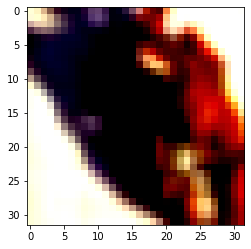

In [ ]:
plt.imshow(np.transpose(data_query_aug_all[5][0,1].detach().cpu().numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


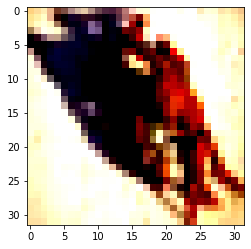

In [ ]:
plt.imshow(np.transpose(data_query[0,1].detach().cpu().numpy(), (1, 2, 0)))